In [1]:
import autogen
import json
import os
import copy
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import statistics

# Load Data

In [2]:
# load the criteria
criteria_file_path = "output/final_filtered_criteria.json"
with open(criteria_file_path) as crit_file:
    criteria = json.load(crit_file)

criteria

{'efficiency': {'description': 'The conciseness of the solution and the use of the most efficient method to solve the problem.',
  'accepted_values': ['inefficient',
   'moderately_efficient',
   'highly_efficient']},
 'accuracy': {'description': 'The correctness of the solution provided for the math problem.',
  'accepted_values': ['0% - Completely incorrect',
   '25% - Partially correct',
   '50% - Mostly correct',
   '75% - Almost correct',
   '100% - Completely correct']},
 'completeness': {'description': 'The extent to which the solution covers all aspects of the problem.',
  'accepted_values': ['0% - Not complete',
   '25% - Partially complete',
   '50% - Mostly complete',
   '75% - Almost complete',
   '100% - Fully complete']},
 'clarity': {'description': 'The ease with which the solution can be understood by the target audience.',
  'accepted_values': ['0% - Not clear',
   '25% - Somewhat clear',
   '50% - Fairly clear',
   '75% - Mostly clear',
   '100% - Very clear']},
 'pre

In [3]:
# load successful and failed sample
def read_without_groundtruth(file_name):
    """
    Read the mathproblem logs - bypassing any information about the ground truths.

    Args:
    - file_name (str): The single log file that wants to get evaluated.

    Returns:
    - str: The log file without any information about the ground truth answer of the problem.
    """
    f = open( file_name,"r").readlines()
    output_dictionary = ""
    for line in f:
        if "is_correct" not in line and "correct_ans" not in line and  "check_result"  not in line:
            output_dictionary += line
        elif "is_correct" in line:
            correctness = line.replace(",","").split(":")[-1].rstrip().strip()
    return [output_dictionary,correctness]

# Reading one successful and one failed example of the task
response_successful = read_without_groundtruth("../test/test_files/agenteval-in-out/samples/sample_math_response_successful.txt")[0]
response_failed = read_without_groundtruth("../test/test_files/agenteval-in-out/samples/sample_math_response_failed.txt")[0]

# Create Adversarial Samples

In [4]:
def create_adversarial_samples(text):
    original_sample = json.loads(text)
    adversarial_sample = copy.deepcopy(original_sample)
    adversarial_sample['messages'] = []
    
    for m in original_sample['messages']: 
        if m['role'] == 'assistant':
            original_content = m['content']
            original_content_list = list(filter(lambda x: len(x) > 0, original_content.replace('. ', '\n').split('\n')))
            frac = 0.5 
            inds = set(random.sample(list(range(len(original_content_list))), int(frac*len(original_content_list))))
            new_content_list = [n for i,n in enumerate(original_content_list) if i not in inds]
            new_content = '\n'.join(new_content_list)
            adversarial_sample['messages'].append({'content': new_content, 'role': 'assistant'})
        else:
            adversarial_sample['messages'].append(m)
    
    return json.dumps(adversarial_sample, indent=2)

In [5]:
print(response_successful)
print(create_adversarial_samples(response_successful))

{
  "problem": "What is the sum of all the distinct positive two-digit factors of 144?",
  "level": "Level 5",
  "type": "Number Theory",
  "solution": "Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$",
  "problem_id": "0",
  "response_with_ans": "To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\nHere's a Python script to accomplish this:\n\n```python\ntwo_digit_factors = []\n\nfor i in range(10, 100):\n    if 144 % i == 0:\n        two_digit_factors.append(i)\n\nsum_of_factors = sum(two_digit_factors)\nprint(\"The sum of all the distinct positive two-digit factors of 144 is:\", sum_of_factors)\n```\n\nPlease run this script to find the desir

# Create Quantifier

In [6]:
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
)

%env AUTOGEN_USE_DOCKER=0

env: AUTOGEN_USE_DOCKER=0


In [7]:
quantifier_message_base = """You are a helpful assistant. You quantify the output of different tasks based on the given criteria.
        You will be given a criterion a dictionary as follows {"description": criterion description , "accepted_values": possible accepted inputs for this key}.
        You are going to evaluate the test case against the given criterion for the given task.
        Return the assessed performance based on accepted values for each criteria, which must be one of the values provided in the accepted_values list.
        Return only the assessed performance and nothing else"""

In [8]:
quantifier_sys_msg = f"""Task: "Math problem solving".
Task description: "Given any question, the system needs to solve the problem as consisely and acccurately as possible"
Task successful example: {response_successful}
Task failed example: {response_failed}
"""

In [ ]:
log_path = "../test/test_files/agenteval-in-out/agentchat_results"

outcome = {}
adversarial_test_cases = {}
quantifier = autogen.AssistantAgent(
    name = "quantifier",
    llm_config = {"config_list": config_list},
    system_message = quantifier_message_base)

for prefix in os.listdir(log_path):
    if prefix == '.DS_Store':
        continue
    for file_name in os.listdir(log_path+"/"+prefix):
        gameid = prefix+"_"+file_name
        
        if file_name.split('.')[-1]=='json':
            test_case , actual_label = read_without_groundtruth(log_path+"/"+prefix+'/'+file_name)

            adversarial_test_case = create_adversarial_samples(test_case)

            adversarial_test_cases[gameid] = adversarial_test_case
            result = {"actual_success": actual_label, "estimated_performance": {}}

            for criterion in criteria:
                quantifier_user = autogen.UserProxyAgent(
                    name = "quantifier_user",
                    max_consecutive_auto_reply = 0,  # terminate without auto-reply
                    human_input_mode = "NEVER",
                )
                cq_results = quantifier_user.initiate_chat(quantifier, message = quantifier_sys_msg + \
                                                "Evaluation criterion: " + criterion + "\n" + \
                                                "Evaluation dictionary: " + str(criteria[criterion]) + "\n" + \
                                                "actual test case to evaluate: " + test_case)
                quantified_result = quantifier_user.last_message()["content"]

                original_result = quantified_result

                quantifier_user = autogen.UserProxyAgent(
                    name = "quantifier_user",
                    max_consecutive_auto_reply = 0,  # terminate without auto-reply
                    human_input_mode = "NEVER",
                )
                cq_results = quantifier_user.initiate_chat(quantifier, message = quantifier_sys_msg + \
                                                "Evaluation criterion: " + criterion + "\n" + \
                                                "Evaluation dictionary: " + str(criteria[criterion]) + "\n" + \
                                                "actual test case to evaluate: " + adversarial_test_case)
                quantified_result = quantifier_user.last_message()["content"]

                adversarial_result = quantified_result

                result['estimated_performance'][criterion] = [original_result, adversarial_result]        
                
        outcome[gameid] = json.dumps(result)
                        
# store the evaluated problems
with open(f"output/adversarial_evaluated_problems.json","w") as file:
    json.dump(outcome,file,indent=2) 

with open(f"output/adversarial_examples.json","w") as file:
    json.dump(adversarial_test_cases,file,indent=2) 

quantifier_user (to quantifier):

Task: "Math problem solving".
Task description: "Given any question, the system needs to solve the problem as consisely and acccurately as possible"
Task successful example: {
  "problem": "What is the sum of all the distinct positive two-digit factors of 144?",
  "level": "Level 5",
  "type": "Number Theory",
  "solution": "Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$",
  "problem_id": "0",
  "response_with_ans": "To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\nHere's a Python script to accomplish this:\n\n```python\ntwo_digit_factors = []\n\nfor i in range(10, 100):\n    if 144 % i == 0:\n        two_d

/opt/anaconda3/lib/python3.11/site-packages/autogen/agentchat/user_proxy_agent.py:83: UserWarning: Using None to signal a default code_execution_config is deprecated. Use {} to use default or False to disable code execution.
  super().__init__(


quantifier (to quantifier_user):

'moderately_efficient'

--------------------------------------------------------------------------------
quantifier_user (to quantifier):

Task: "Math problem solving".
Task description: "Given any question, the system needs to solve the problem as consisely and acccurately as possible"
Task successful example: {
  "problem": "What is the sum of all the distinct positive two-digit factors of 144?",
  "level": "Level 5",
  "type": "Number Theory",
  "solution": "Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$",
  "problem_id": "0",
  "response_with_ans": "To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\nHere'

/opt/anaconda3/lib/python3.11/site-packages/autogen/agentchat/user_proxy_agent.py:83: UserWarning: Using None to signal a default code_execution_config is deprecated. Use {} to use default or False to disable code execution.
  super().__init__(


quantifier (to quantifier_user):

'100% - Completely correct'

--------------------------------------------------------------------------------
quantifier_user (to quantifier):

Task: "Math problem solving".
Task description: "Given any question, the system needs to solve the problem as consisely and acccurately as possible"
Task successful example: {
  "problem": "What is the sum of all the distinct positive two-digit factors of 144?",
  "level": "Level 5",
  "type": "Number Theory",
  "solution": "Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$",
  "problem_id": "0",
  "response_with_ans": "To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\n

# Plot

In [17]:
# convert accepted value to score
level2score = {}
for criterion in criteria:
     score = 0
     for v in criteria[criterion]["accepted_values"]:
        level2score[v] = score
        score += 1
print(level2score)

{'inefficient': 0, 'moderately_efficient': 1, 'highly_efficient': 2, '0% - Completely incorrect': 0, '25% - Partially correct': 1, '50% - Mostly correct': 2, '75% - Almost correct': 3, '100% - Completely correct': 4, '0% - Not complete': 0, '25% - Partially complete': 1, '50% - Mostly complete': 2, '75% - Almost complete': 3, '100% - Fully complete': 4, '0% - Not clear': 0, '25% - Somewhat clear': 1, '50% - Fairly clear': 2, '75% - Mostly clear': 3, '100% - Very clear': 4, 'poor': 0, 'fair': 1, 'excellent': 2, '0% - No steps delineated': 0, '25% - Few steps delineated': 1, '50% - Some steps delineated': 2, '75% - Most steps delineated': 3, '100% - All steps delineated': 4, '0-15 sec': 0, '16-30 sec': 1, '31-60 sec': 2, '1-3 min': 3, '3-5 min': 4, '>5 min': 5, 'inconsistent': 0, 'mostly consistent': 1, 'consistent': 2, 'none': 0, 'some steps': 1, 'half steps': 2, 'most steps': 3, 'all steps': 4, 'Ignored all errors': 0, 'Handled very few errors': 1, 'Handled some errors': 2, 'Handled mo

In [18]:
adversarial_performance = defaultdict(lambda: defaultdict(int))# adversarial_performance[criterion] = {"better": cnt, "same": cnt, "worse": cnt}
key_errors = defaultdict(int)

for game in outcome:
    evaluated_results = json.loads(outcome[game])['estimated_performance']
    for criterion in evaluated_results:
        original_level, adversarial_level = evaluated_results[criterion]
        
        try: 
            original_score = level2score[original_level.strip('"').strip("'")]
            adversarial_score = level2score[adversarial_level.strip('"').strip("'")]
        except:
            if not original_level.strip('"').strip("'") in level2score.keys():
                key_errors[original_level.strip('"').strip("'")] += 1
            if not adversarial_level.strip('"').strip("'") in level2score.keys():
                key_errors[adversarial_level.strip('"').strip("'")] += 1
            continue
                
        comparison = 'better'
        if adversarial_score == original_score:
            comparison = 'same'
            if adversarial_score == 0:
                comparison = 'lowest'
            elif adversarial_score == len(criteria[criterion]['accepted_values']) - 1:
                comparison = 'highest'
        elif adversarial_score < original_score:
            comparison = 'worse'
        adversarial_performance[criterion][comparison] += 1

print(key_errors)

defaultdict(<class 'int'>, {'Counting & Probability': 6, 'Intermediate Algebra': 11, 'Precalculus': 12, 'Prealgebra': 4})


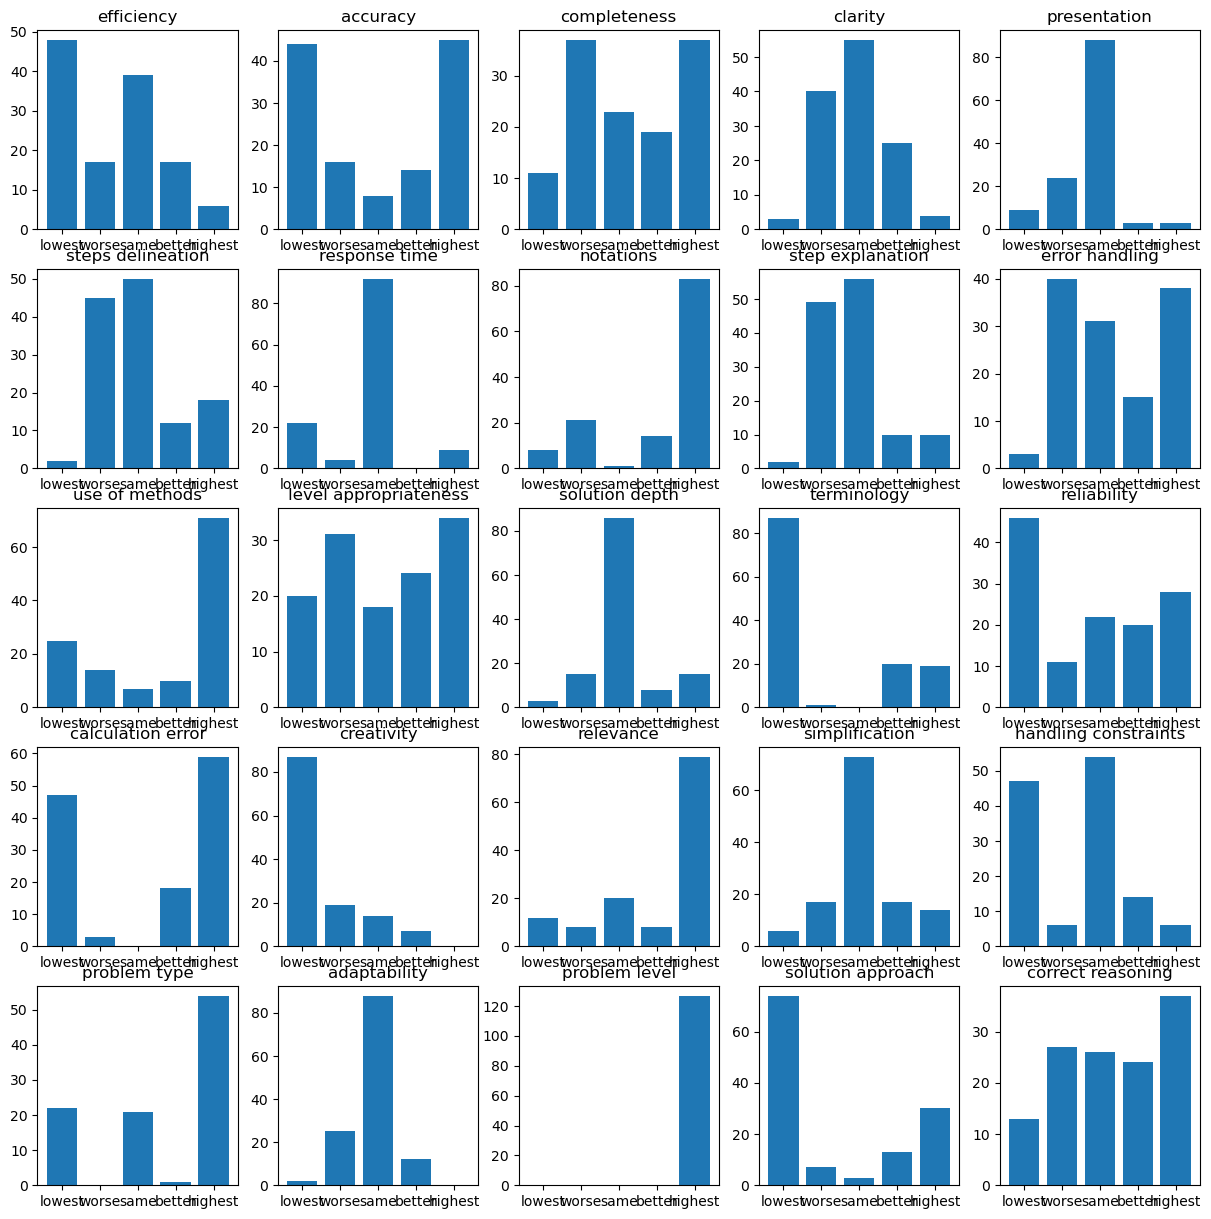

In [19]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

comparisons = ["lowest", "worse", "same", "better", "highest"]

for index, criterion in enumerate(adversarial_performance):
    counts = [adversarial_performance[criterion]['lowest'], adversarial_performance[criterion]['worse'], adversarial_performance[criterion]['same'], adversarial_performance[criterion]['better'], adversarial_performance[criterion]['highest']]
    axs[index//5, index%5].bar(comparisons, counts)
    axs[index//5, index%5].title.set_text(criterion)

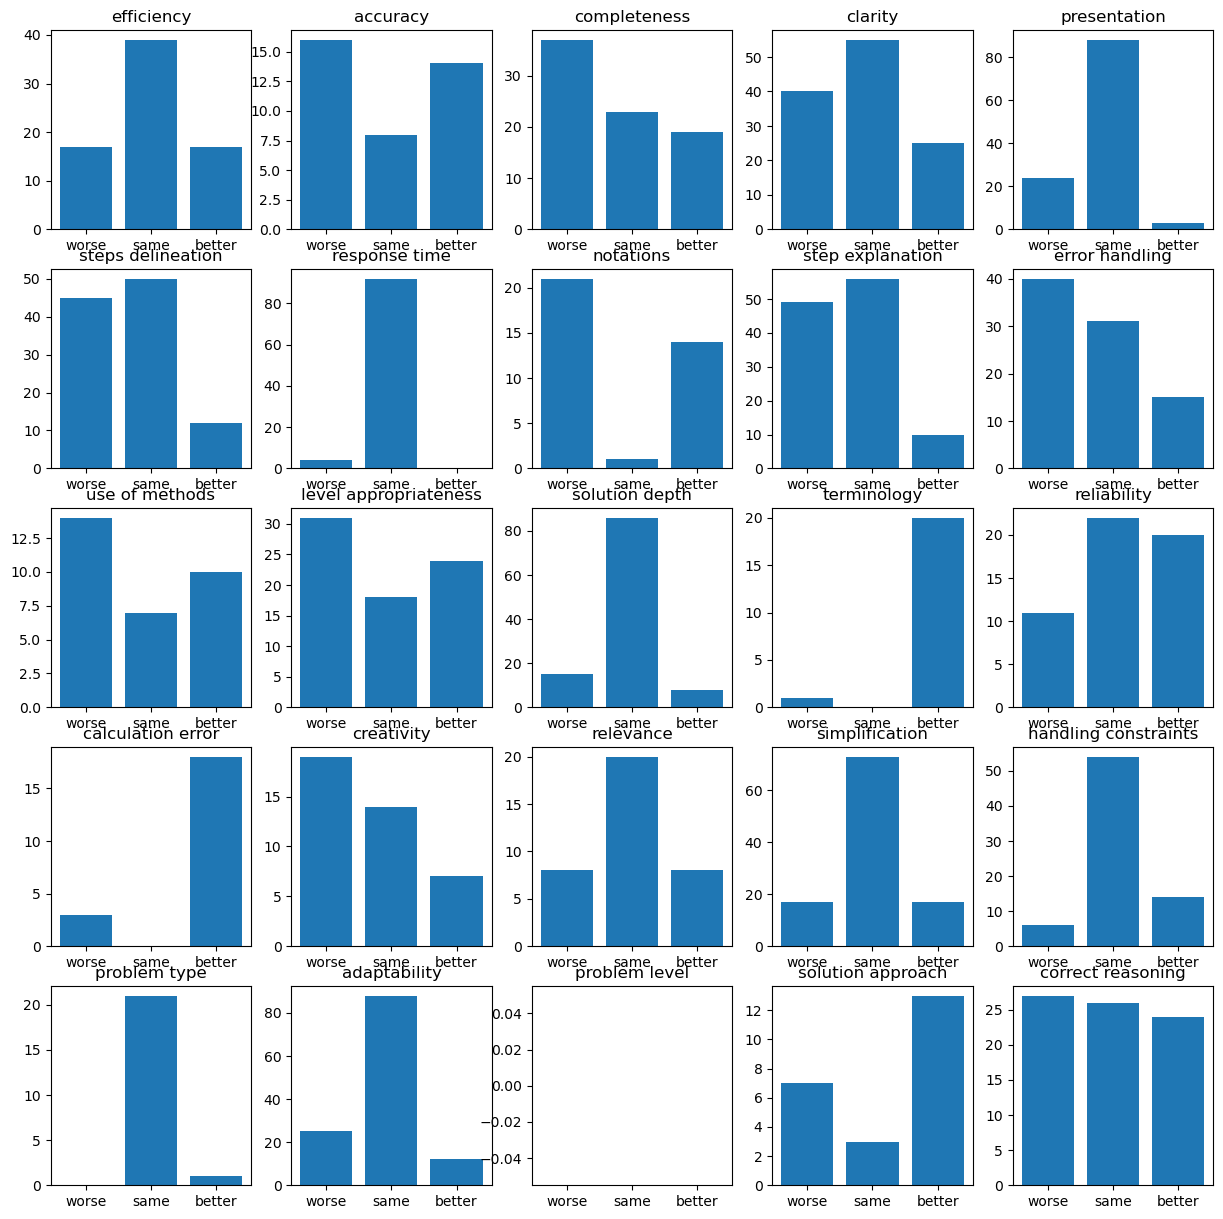

In [20]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

comparisons = ["worse", "same", "better"]

for index, criterion in enumerate(adversarial_performance):
    counts = [adversarial_performance[criterion]['worse'], adversarial_performance[criterion]['same'], adversarial_performance[criterion]['better']]
    axs[index//5, index%5].bar(comparisons, counts)
    axs[index//5, index%5].title.set_text(criterion)

In [21]:
fig.savefig('adversarial_performance.png')